We will use this python notebook to plot graphs.

In [175]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# change below files to include your own
working_dir = "~/remote_files/jetson_xaviar/projects/video_lcp/build"
mpc_csv = working_dir + "/diff_mpc.csv"
basic_csv = working_dir + "/diff_basic.csv"
pid_csv = working_dir + "/diff_pid.csv"

In [176]:
header_names = ["FrameNum", "DesiredModel", "UsedModel", "TimeOnNetwork"]
df_mpc = pd.read_csv(mpc_csv, delimiter=",", header=None, names=header_names)
df_basic = pd.read_csv(basic_csv, delimiter=",", header=None, names=header_names)
df_pid = pd.read_csv(pid_csv, delimiter=",", header=None, names=header_names)

In [177]:
def show_models(data, ax, title=""):
    ax.scatter(data["FrameNum"], data["DesiredModel"], label="DesiredModel")
    ax.scatter(data["FrameNum"], data["UsedModel"], label="UsedModel")
    ax.set_ylim([0,15])
    ax.set_xlim([0,6000])
    ax.set_title(title)
    ax.set_xlabel("Frames")
    ax.set_ylabel("Model Number")
    ax.legend()

def show_rtt(data, ax, title=""):
    ax.scatter(data["FrameNum"], data["TimeOnNetwork"], label="RTT (ms)")
    ax.axhline(33, xmin=0,xmax=1, ls="-", lw=1.5,c="r")

    ax.set_ylim([0,50])
    ax.set_xlim([0,6000])
    ax.set_title(title)
    ax.set_xlabel("Frames")
    ax.set_ylabel("RTT (ms)")
    
def show_models_rtt(data, title=""):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,7))
    show_models(data, ax[0], title)
    show_rtt(data, ax[1], title)

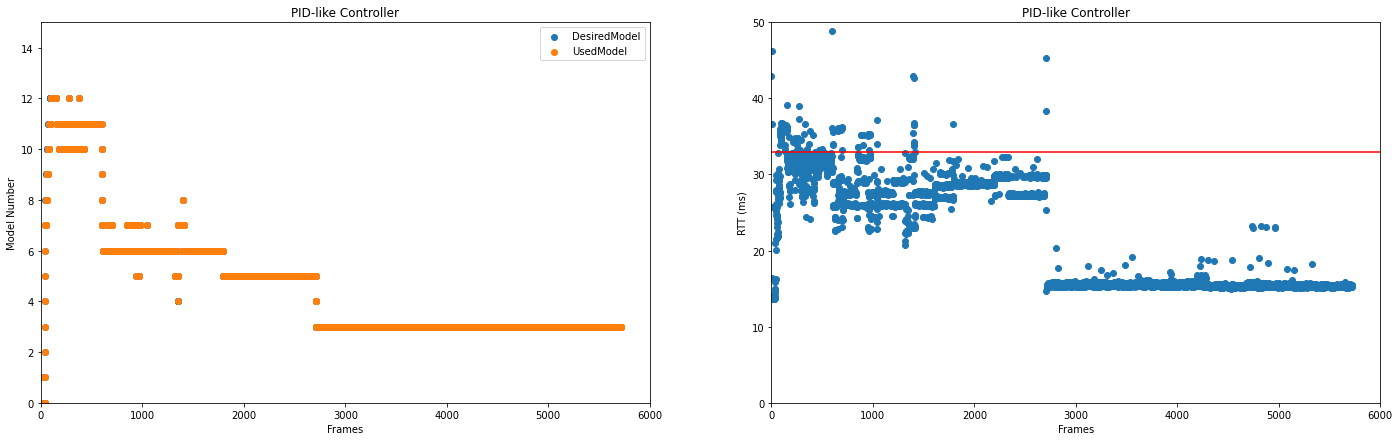

In [178]:
# show_models_rtt(df_mpc, "MPC Controller")
show_models_rtt(df_pid, "PID-like Controller")

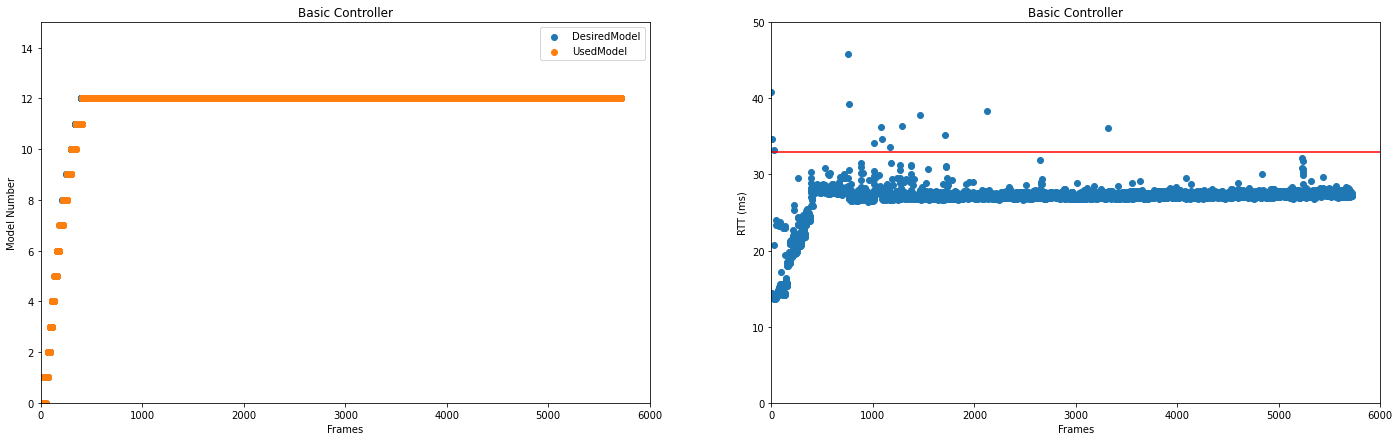

In [160]:

show_models_rtt(df_basic, "Basic Controller")

In [155]:
# Number of deadline misses
def deadline_misses(df):
    count = len(df[df["TimeOnNetwork"] > 33])
    total = len(df)
    return (count / total) * 100

print("Deadline misses")
print("PID: {:.2f}".format(deadline_misses(df_pid)))
print("Basic: {:.2f}".format(deadline_misses(df_basic)))

Deadline misses
PID: 9.12
Basic: 0.24


In [44]:
# Check the models that MPC selected for the frames misssed by the basic controller
frame_missed = df_basic[df_basic["TimeOnNetwork"] > 33]["FrameNum"].tolist()
mpc_networktime = df_mpc[df_mpc["FrameNum"].isin(frame_missed)]
mpc_networktime

FrameNum  DesiredModel  UsedModel  TimeOnNetwork
500        500            14         14         35.913
505        505            14         14         38.296
633        633            14         14         38.300
646        646            14         14         41.026
1078      1078            14         14         39.989

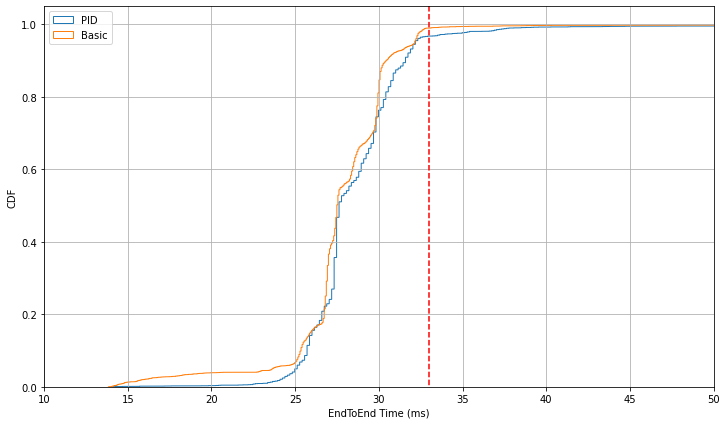

In [45]:
# Plot CDF here
def plot_cdf(data, ax, label, n_bins=200):
    n, bins, patches = ax.hist(data, n_bins, density=True, histtype='step', cumulative=True, label=label)

plt.figure(figsize=(12, 7))
plot_cdf(df_pid["TimeOnNetwork"], plt, "PID", 1000)
plot_cdf(df_basic["TimeOnNetwork"], plt, "Basic", 1000)
plt.axvline(33, ymax=0, ymin=1, color="red", ls="--")
plt.xlim([10, 50])
plt.grid()
plt.xlabel("EndToEnd Time (ms)")
plt.ylabel("CDF")
plt.legend()
plt.show()

In [64]:
# Here, we will try plot error in prediction in network time and model prediction time.
# error = (measured_value - predicted_value)
def plot_error(data):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24,7))
    ax[0].scatter(data["FrameNum"], data["NetworkTime"])
    ax[1].scatter(data["FrameNum"], data["ModelPredTime"])
    ax[0].set_title("NetworkTime")
    ax[1].set_title("ModelPredTime")
    ax[0].set_ylim([-10,10])
    ax[1].set_ylim([-10,10])
    for i in range(2):
        ax[i].set_xlabel("Frames")
        ax[0].set_ylabel("Error (ms)")
    plt.show()

# Error in CDF
def plot_error_cdf(data):
    plt.figure(figsize=(12, 7))
    plot_cdf(data["NetworkTime"], plt, "NetworkTime")
    plot_cdf(data["ModelPredTime"], plt, "ModelPredTime")
    plt.axvline(33, ymax=0, ymin=1, color="red", ls="--")
    plt.xlim([-10, 10])
    plt.grid()
    plt.legend()
    plt.xlabel("Error (ms)")
    plt.ylabel("CDF")
    plt.show()

In [65]:
mpc_error = working_dir + "/mpc_error.csv"
df_mpc_error = pd.read_csv(mpc_error, delimiter=",", header=None, names=["FrameNum", "NetworkTime", "ModelPredTime"])
# plot_error(df_mpc_error)

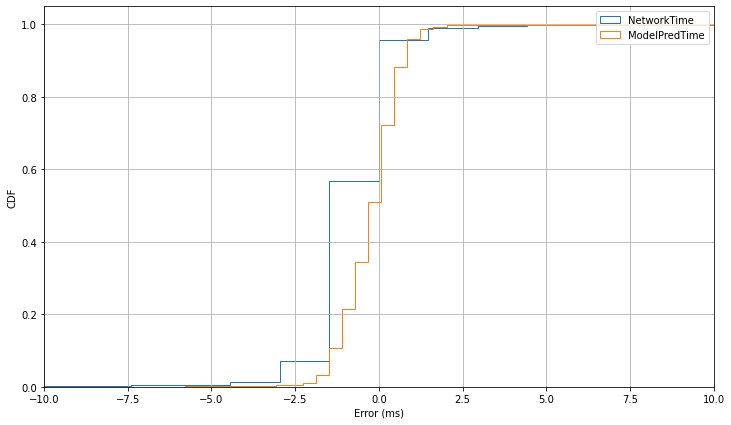

In [66]:
plot_error_cdf(df_mpc_error)

In [67]:
# Load measured and predicted stats
header_names = ["FrameNum", "EndToTime", "NetworkTime", "ModelPredTime", "NetworkSize", "DesiredModel", "Throughput"]
df_mpc_desired_model_prediction = pd.read_csv(working_dir + "/mpc_desired_model_prediction.csv", delimiter=",", header=None, names=header_names)

df_mpc_used_model_prediction = pd.read_csv(working_dir + "/mpc_used_model_prediction.csv", delimiter=",", header=None, names=header_names)

header_names[-1] = "UsedModel"
df_mpc_measured = pd.read_csv(working_dir + "/mpc_measured.csv", delimiter=",", header=None, names=header_names)

In [68]:
import numpy as np
# Plot difference in encoded sise prediction
def plot_scatter(x, y, xlabel, ylabel):
    plt.figure(figsize=(12,7))
    plt.scatter(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

encoded_size_error = df_mpc_measured["NetworkSize"] - df_mpc_desired_model_prediction["NetworkSize"]
encoded_networkTimeError = (encoded_size_error * 8) / df_mpc_desired_model_prediction["Throughput"]

# plot_scatter(df_mpc_measured["FrameNum"], encoded_size_error, "FrameNum", "Encoded Size Error")
# plot_scatter(df_mpc_measured["FrameNum"], encoded_networkTimeError, "FrameNum", "Network Time Error (ms)")

encoded_networkTimeError = encoded_networkTimeError.replace([np.inf, -np.inf], np.nan)

# plt.figure(figsize=(12, 7))
# plot_cdf(encoded_networkTimeError, plt, "NetworkTime")
# plt.axvline(33, ymax=0, ymin=1, color="red", ls="--")
# plt.xlim([-10, 10])
# plt.grid()
# plt.legend()
# plt.xlabel("Error (ms)")
# plt.ylabel("CDF")
# plt.show()

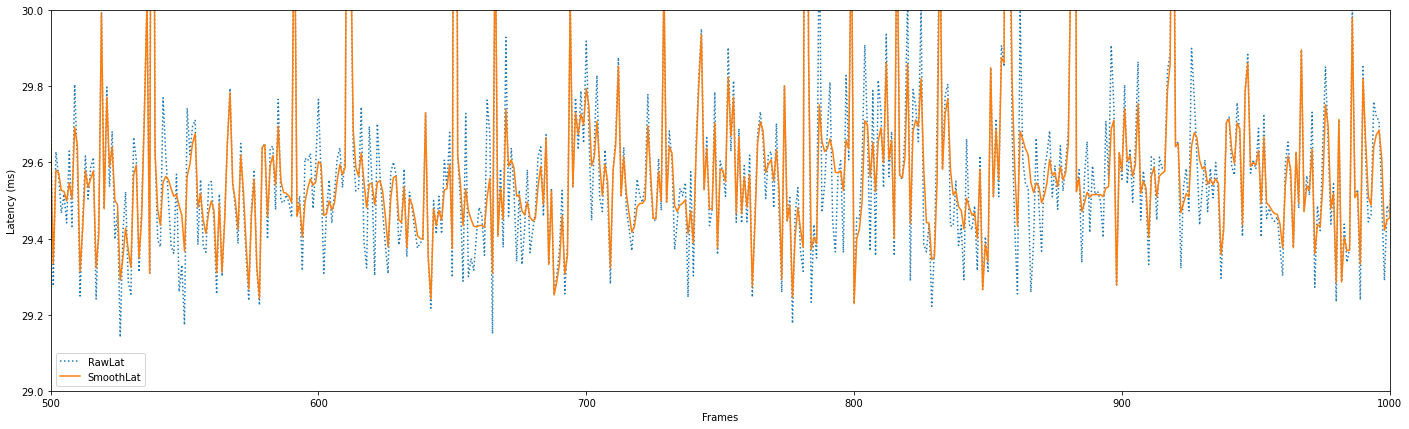

In [27]:
# Here, we plot latency with and without smoothing filter
header_names = ["RawLat", "SmoothLat"]
df_lat_smooth = pd.read_csv(working_dir + "/lat_smooth.csv", delimiter=",", header=None, names=header_names)

def plot_lat_smooth(data, title=""):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24,7))
    ax.plot(data["RawLat"], label="RawLat", ls="dotted")
    ax.plot(data["SmoothLat"], label="SmoothLat")
    ax.set_ylim([29,30])
    ax.set_xlim([500,1000])
    ax.set_title(title)
    ax.set_xlabel("Frames")
    ax.set_ylabel("Latency (ms)")
    ax.legend()

plot_lat_smooth(df_lat_smooth)